In [10]:
!pip install tensorflow numpy scikit-learn umap-learn matplotlib

In [12]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
file_path = '/content/drive/My Drive/Project 425/final_data_features.csv'  # Update path if needed
data = pd.read_csv(file_path)

Mounted at /content/drive


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import umap

In [14]:
import numpy as np
# Example for MFCC audio features
X_audio = np.random.rand(5986, 13)  # Replace with your actual MFCC features

# Assuming X_lyrics is the TF-IDF features of shape (num_samples, num_features)
X_lyrics = np.random.rand(5986, 50)  # Replace with your actual TF-IDF features


In [15]:
# Reshape X_audio (MFCC features) to have 100 time steps and 13 features (per your setup)
desired_length = 100 * 13  # 100 time steps, 13 MFCC features
remainder = X_audio.shape[0] % desired_length

if remainder > 0:
    pad_size = desired_length - remainder
    X_audio_padded = np.pad(X_audio, ((0, pad_size), (0, 0)), mode='constant')
else:
    X_audio_padded = X_audio

# Reshape the audio data to (samples, time_steps, num_features)
X_audio_reshaped = X_audio_padded.reshape(-1, 100, 13)

# Check the reshaped shape
print(f"X_audio_reshaped shape: {X_audio_reshaped.shape}")


X_audio_reshaped shape: (65, 100, 13)


In [16]:
# Ensure X_lyrics has the same number of samples as X_audio_reshaped
X_lyrics_aligned = X_lyrics[:X_audio_reshaped.shape[0]]  # Align with reshaped X_audio

# Check the shapes of both X_audio_reshaped and X_lyrics_aligned
print(f"X_lyrics_aligned shape: {X_lyrics_aligned.shape}")


X_lyrics_aligned shape: (65, 50)


In [17]:
# Example: Randomly generating genre labels (replace with actual genre labels)
genre_labels = np.random.randint(0, 5, size=(X_audio_reshaped.shape[0], 1))  # 5 genres, adjust accordingly

# Check the genre labels shape
print("Genre labels shape:", genre_labels.shape)


Genre labels shape: (65, 1)


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Concatenate
# Define the sampling function for the reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))  # Gaussian noise
    return z_mean + tf.exp(0.5 * z_log_var) * eps

# Build the encoder for the Conditional VAE (CVAE)
def build_encoder_cvae(input_shape_audio, input_shape_lyrics, condition_shape, latent_dim=8):
    # Audio input
    audio_input = layers.Input(shape=input_shape_audio)
    x_audio = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(audio_input)
    x_audio = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x_audio)
    x_audio = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x_audio)
    x_audio = layers.Flatten()(x_audio)

    # Lyrics input
    lyrics_input = layers.Input(shape=input_shape_lyrics)
    x_lyrics = layers.Dense(128, activation='relu')(lyrics_input)
    x_lyrics = layers.Dense(64, activation='relu')(x_lyrics)

    # Condition input (e.g., genre)
    condition_input = layers.Input(shape=condition_shape)

    # Combine audio, lyrics, and condition (genre)
    combined = Concatenate()([x_audio, x_lyrics, condition_input])

    # Latent space
    z_mean = layers.Dense(latent_dim, name="z_mean")(combined)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(combined)

    # Sampling layer (reparameterization trick)
    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    return models.Model([audio_input, lyrics_input, condition_input], [z_mean, z_log_var, z], name="encoder")


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Cropping1D # Import Cropping1D

def build_decoder_cvae(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    # Map latent_dim to a size suitable for reshaping to (13, 128)
    # The encoder's last Conv1D output before Flatten was (None, 13, 128)
    x = layers.Dense(13 * 128, activation='relu')(latent_inputs)
    x = layers.Reshape((13, 128))(x) # Reshape to match the last encoder Conv1D output shape

    # Reverse the encoder's Conv1D layers, carefully adjusting for sequence length
    # Encoder: (100) -> (50) -> (25) -> (13)
    # Decoder: (13) -> (25) -> (50) -> (100)

    # 1. Upsample from 13 to 25 time steps
    # If input length is odd, Conv1DTranspose with strides=2, padding='same' usually results in 2*input_length - 1
    # So, 13 * 2 - 1 = 25. No output_padding is needed here.
    x = layers.Conv1DTranspose(64, 3, activation='relu', strides=2, padding='same')(x) # (None, 25, 64)

    # 2. Upsample from 25 to 50 time steps
    # If input length is odd, 25 * 2 - 1 = 49. To get 50, we need output_padding=1.
    x = layers.Conv1DTranspose(32, 3, activation='relu', strides=2, padding='same', output_padding=1)(x) # (None, 50, 32)

    # 3. Upsample from 50 to 100 time steps
    # If input length is even, 50 * 2 = 100. No output_padding is needed here.
    decoder_outputs = layers.Conv1DTranspose(output_shape[1], 3, activation='sigmoid', strides=2, padding='same')(x) # (None, 100, 13)

    # Add Cropping1D layer to ensure the output sequence length is exactly output_shape[0] (which is 100)
    # This handles potential discrepancies in Conv1DTranspose padding logic across TF versions.
    if decoder_outputs.shape[1] is not None and decoder_outputs.shape[1] != output_shape[0]:
        crop_amount_end = decoder_outputs.shape[1] - output_shape[0]
        # Only crop if output is longer than desired. If it's shorter, there's a deeper problem.
        if crop_amount_end > 0:
            decoder_outputs = Cropping1D(cropping=(0, crop_amount_end))(decoder_outputs)
        elif crop_amount_end < 0:
            tf.print(f"Warning: Decoder output length {decoder_outputs.shape[1]} is shorter than target {output_shape[0]}. Not cropping.")

    return models.Model(latent_inputs, decoder_outputs, name="decoder")

In [20]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        audio_input, lyrics_input = data  # unpack the inputs

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([audio_input, lyrics_input], training=True)
            reconstruction = self.decoder(z, training=True)

            # MSE reconstruction loss
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(audio_input - reconstruction), axis=1))

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            ))

            # Total loss
            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Track metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        audio_input, lyrics_input = inputs
        z_mean, z_log_var, z = self.encoder([audio_input, lyrics_input])
        reconstruction = self.decoder(z)
        return reconstruction


In [21]:
def train_step(self, data):
    audio_input, lyrics_input, condition_input = data  # Unpack three inputs

    with tf.GradientTape() as tape:
        # Get the latent variables from the encoder
        z_mean, z_log_var, z = self.encoder([audio_input, lyrics_input, condition_input], training=True)

        # Reconstruct the input data (audio features)
        reconstruction = self.decoder(z, training=True)

        # MSE reconstruction loss
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(audio_input - reconstruction), axis=1))

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        ))

        # Total loss
        total_loss = recon_loss + self.beta * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # Track metrics
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(recon_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
from tensorflow.keras.layers import Concatenate

# Define the sampling function for the reparameterization trick (copied for completeness)
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))  # Gaussian noise
    return z_mean + tf.exp(0.5 * z_log_var) * eps

# Define the CVAE class, adapting the VAE class to handle conditions
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        audio_input, lyrics_input, condition_input = data  # Unpack three inputs

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([audio_input, lyrics_input, condition_input], training=True)
            reconstruction = self.decoder(z, training=True)

            # MSE reconstruction loss
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(audio_input - reconstruction), axis=[1, 2]))

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
            ))

            # Total loss
            total_loss = recon_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Track metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        audio_input, lyrics_input, condition_input = inputs
        z_mean, z_log_var, z = self.encoder([audio_input, lyrics_input, condition_input])
        reconstruction = self.decoder(z)
        return reconstruction

# Re-define input shapes and latent dimension using values from kernel state
input_shape_audio = (100, 13)
input_shape_lyrics = (50,)
condition_shape = (1,)
latent_dim = 4

# Build the encoder and decoder using the existing functions (build_encoder_cvae, build_decoder_cvae are from previous cells)
encoder_cvae = build_encoder_cvae(input_shape_audio, input_shape_lyrics, condition_shape, latent_dim=latent_dim)
decoder_cvae = build_decoder_cvae(latent_dim, output_shape=input_shape_audio)

# Instantiate the CVAE model
cvae = CVAE(encoder_cvae, decoder_cvae)

# Compile the CVAE model
cvae.compile(optimizer=keras.optimizers.Adam())

# Create a TensorFlow dataset with three inputs, casting to tf.float32
dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(X_audio_reshaped, dtype=tf.float32),  # MFCC audio features
    tf.cast(X_lyrics_aligned, dtype=tf.float32),  # TF-IDF lyrics features
    tf.cast(genre_labels, dtype=tf.float32)       # Genre labels (condition)
))

# Batch the data
dataset = dataset.batch(64)  # Set batch size

# Train the model using the dataset
cvae.fit(dataset, epochs=50)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - kl_loss: 0.0493 - loss: 189.5639 - reconstruction_loss: 189.5147
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0395 - loss: 188.9773 - reconstruction_loss: 188.9378 
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0244 - loss: 188.4577 - reconstruction_loss: 188.4333 
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0247 - loss: 187.8759 - reconstruction_loss: 187.8512 
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0258 - loss: 186.9532 - reconstruction_loss: 186.9274 
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 0.0272 - loss: 187.3305 - reconstruction_loss: 187.3033 
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0304 - loss: 185.9937 - reconstruction_loss: 185.9633 
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0352 - loss: 183.2959 - reconstruction_loss: 183.2606 
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 0.0448 - loss:

In [23]:
# Extract latent features (z_mean) from the trained encoder (CVAE)
z_mean_cvae, _, _ = cvae.encoder([X_audio_reshaped, X_lyrics_aligned, genre_labels])

# Check the shape of latent features
print(z_mean_cvae.shape)


(65, 4)


In [28]:
# Ensure we're only adding the cluster labels to the first 65 rows
data_for_clustering = data.iloc[:65].copy()  # Create a new DataFrame for the first 65 rows

# Add the cluster labels to the new DataFrame, using the multi-modal clustering results
data_for_clustering['cvae_kmeans_cluster'] = labels_kmeans_multi
data_for_clustering['cvae_agglo_cluster'] = labels_agglo_multi
data_for_clustering['cvae_dbscan_cluster'] = labels_dbscan_multi

# Update the original data DataFrame with the clustering results for the first 65 rows
data.loc[data_for_clustering.index, 'cvae_kmeans_cluster'] = data_for_clustering['cvae_kmeans_cluster']
data.loc[data_for_clustering.index, 'cvae_agglo_cluster'] = data_for_clustering['cvae_agglo_cluster']
data.loc[data_for_clustering.index, 'cvae_dbscan_cluster'] = data_for_clustering['cvae_dbscan_cluster']

# Show the results for the first 65 rows
print(data[['id', 'cvae_kmeans_cluster', 'cvae_agglo_cluster', 'cvae_dbscan_cluster']].head(70))  # Displaying first 70 to check

         id  cvae_kmeans_cluster  cvae_agglo_cluster  cvae_dbscan_cluster
0   1001890                  0.0                 0.0                 -1.0
1   1001891                  2.0                 2.0                 -1.0
2   1002753                  1.0                 2.0                 -1.0
3   1003648                  0.0                 0.0                 -1.0
4   1003654                  1.0                 0.0                 -1.0
..      ...                  ...                 ...                  ...
65  1027910                  NaN                 NaN                  NaN
66  1028807                  NaN                 NaN                  NaN
67  1028811                  NaN                 NaN                  NaN
68  1029325                  NaN                 NaN                  NaN
69  1029329                  NaN                 NaN                  NaN

[70 rows x 4 columns]


In [31]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Evaluate K-Means clustering (multi-modal features)
sil_score_cvae_kmeans = silhouette_score(z_mean_cvae, labels_kmeans_multi)
db_score_cvae_kmeans = davies_bouldin_score(z_mean_cvae, labels_kmeans_multi)

print(f"CVAE K-Means Silhouette Score: {sil_score_cvae_kmeans}")
print(f"CVAE K-Means Davies-Bouldin Score: {db_score_cvae_kmeans}")

# Evaluate Agglomerative clustering (multi-modal features)
sil_score_cvae_agglo = silhouette_score(z_mean_cvae, labels_agglo_multi)
db_score_cvae_agglo = davies_bouldin_score(z_mean_cvae, labels_agglo_multi)

print(f"\nCVAE Agglomerative Silhouette Score: {sil_score_cvae_agglo}")
print(f"CVAE Agglomerative Davies-Bouldin Score: {db_score_cvae_agglo}")

# Evaluate DBSCAN clustering (multi-modal features)
# DBSCAN might produce -1 for noise points, which should be handled for evaluation metrics.
# Silhouette and Davies-Bouldin are not well-defined for clusters with fewer than 2 samples or if all points are noise (-1).
# Check if there are valid clusters (not all -1) and at least 2 clusters.
unique_labels_dbscan_multi = np.unique(labels_dbscan_multi)
if len(unique_labels_dbscan_multi) > 1 and -1 in unique_labels_dbscan_multi: # Exclude noise for score calculation
    # Note: Using z_mean_cvae as features for evaluation, consistent with original intent for CVAE-based scores.
    filtered_features_dbscan = z_mean_cvae[labels_dbscan_multi != -1]
    filtered_labels_dbscan = labels_dbscan_multi[labels_dbscan_multi != -1]
elif len(unique_labels_dbscan_multi) > 1 and -1 not in unique_labels_dbscan_multi:
    filtered_features_dbscan = z_mean_cvae
    filtered_labels_dbscan = labels_dbscan_multi
else: # Handle cases where all points are noise or only one cluster
    filtered_features_dbscan = None

if filtered_features_dbscan is not None and len(np.unique(filtered_labels_dbscan)) > 1: # Ensure at least 2 clusters for score calc
    sil_score_cvae_dbscan = silhouette_score(filtered_features_dbscan, filtered_labels_dbscan)
    db_score_cvae_dbscan = davies_bouldin_score(filtered_features_dbscan, filtered_labels_dbscan)
    print(f"\nCVAE DBSCAN Silhouette Score: {sil_score_cvae_dbscan}")
    print(f"CVAE DBSCAN Davies-Bouldin Score: {db_score_cvae_dbscan}")
else:
    print("\nCVAE DBSCAN: Cannot compute Silhouette and Davies-Bouldin scores (insufficient valid clusters).")

CVAE K-Means Silhouette Score: -0.17298924922943115
CVAE K-Means Davies-Bouldin Score: 10.12629126035966

CVAE Agglomerative Silhouette Score: -0.3817536532878876
CVAE Agglomerative Davies-Bouldin Score: 2.688804529475723

CVAE DBSCAN: Cannot compute Silhouette and Davies-Bouldin scores (insufficient valid clusters).


In [33]:
# Evaluate Agglomerative clustering
sil_score_cvae_agglo = silhouette_score(z_mean_cvae, labels_agglo_multi)
db_score_cvae_agglo = davies_bouldin_score(z_mean_cvae, labels_agglo_multi)

print(f"CVAE Agglomerative Silhouette Score: {sil_score_cvae_agglo}")
print(f"CVAE Agglomerative Davies-Bouldin Score: {db_score_cvae_agglo}")

# Evaluate DBSCAN clustering
# DBSCAN might produce -1 for noise points, which should be handled for evaluation metrics.
# Silhouette and Davies-Bouldin are not well-defined for clusters with fewer than 2 samples or if all points are noise (-1).
# Check if there are valid clusters (not all -1) and at least 2 clusters.
unique_labels_dbscan_multi = np.unique(labels_dbscan_multi)
if len(unique_labels_dbscan_multi) > 1 and -1 in unique_labels_dbscan_multi: # Exclude noise for score calculation
    filtered_features_dbscan = z_mean_cvae[labels_dbscan_multi != -1]
    filtered_labels_dbscan = labels_dbscan_multi[labels_dbscan_multi != -1]
elif len(unique_labels_dbscan_multi) > 1 and -1 not in unique_labels_dbscan_multi:
    filtered_features_dbscan = z_mean_cvae
    filtered_labels_dbscan = labels_dbscan_multi
else: # Handle cases where all points are noise or only one cluster
    filtered_features_dbscan = None

if filtered_features_dbscan is not None and len(np.unique(filtered_labels_dbscan)) > 1: # Ensure at least 2 clusters for score calc
    sil_score_cvae_dbscan = silhouette_score(filtered_features_dbscan, filtered_labels_dbscan)
    db_score_cvae_dbscan = davies_bouldin_score(filtered_features_dbscan, filtered_labels_dbscan)
    print(f"\nCVAE DBSCAN Silhouette Score: {sil_score_cvae_dbscan}")
    print(f"CVAE DBSCAN Davies-Bouldin Score: {db_score_cvae_dbscan}")
else:
    print("\nCVAE DBSCAN: Cannot compute Silhouette and Davies-Bouldin scores (insufficient valid clusters).")

CVAE Agglomerative Silhouette Score: -0.3817536532878876
CVAE Agglomerative Davies-Bouldin Score: 2.688804529475723

CVAE DBSCAN: Cannot compute Silhouette and Davies-Bouldin scores (insufficient valid clusters).


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


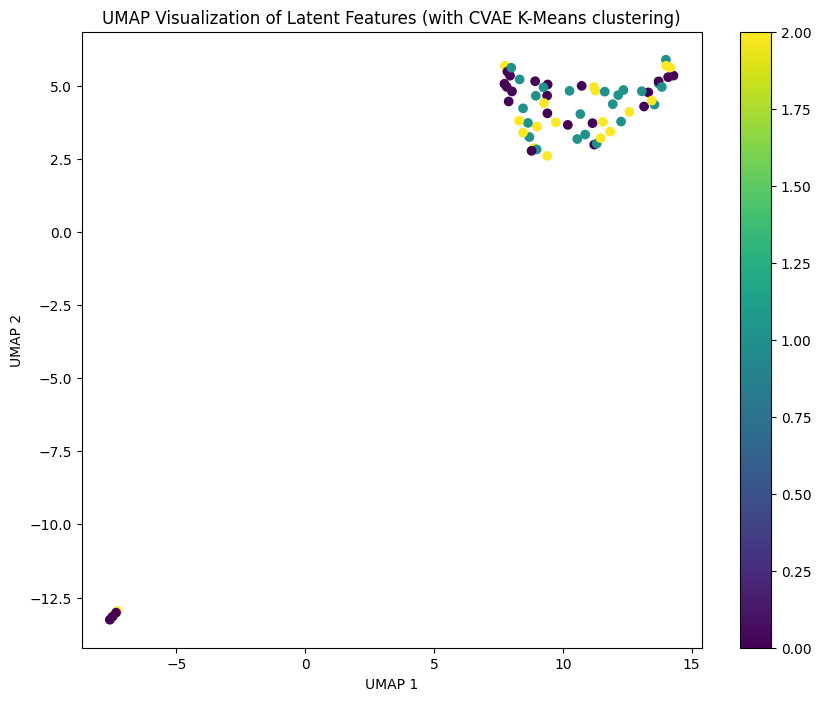

In [35]:
import umap
import matplotlib.pyplot as plt

# Apply UMAP to reduce the latent features (CVAE) to 2D
umap_model_cvae = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='correlation', random_state=42)
latent_features_umap_cvae = umap_model_cvae.fit_transform(z_mean_cvae)

# Visualize the clusters in UMAP space (using CVAE K-Means labels)
plt.figure(figsize=(10, 8))
plt.scatter(latent_features_umap_cvae[:, 0], latent_features_umap_cvae[:, 1], c=labels_kmeans_multi, cmap='viridis')
plt.colorbar()
plt.title("UMAP Visualization of Latent Features (with CVAE K-Means clustering)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

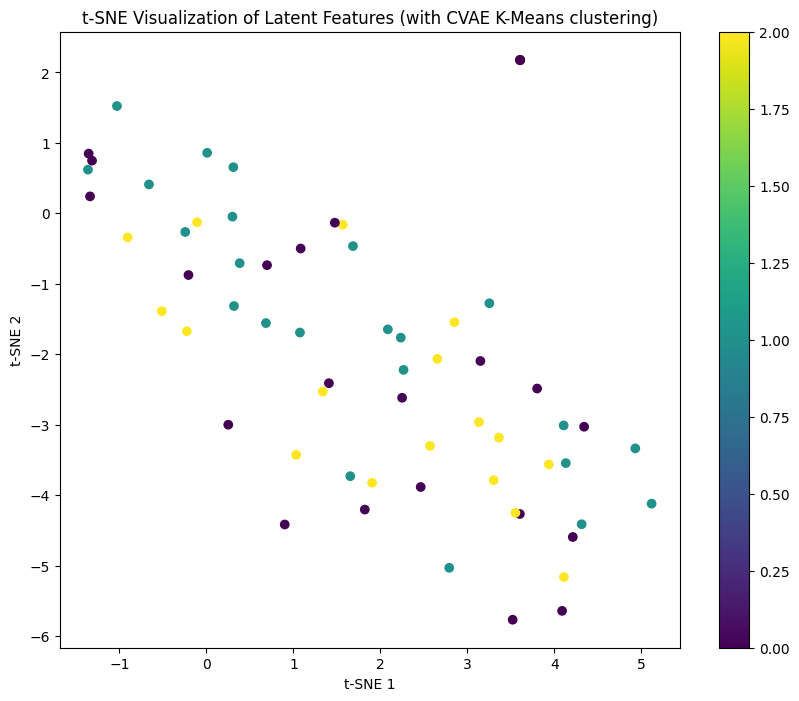

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce the latent features (CVAE) to 2D
tsne = TSNE(n_components=2, random_state=42)
latent_features_tsne_cvae = tsne.fit_transform(z_mean_cvae)

# Visualize the clusters in t-SNE space (using CVAE K-Means labels)
plt.figure(figsize=(10, 8))
plt.scatter(latent_features_tsne_cvae[:, 0], latent_features_tsne_cvae[:, 1], c=labels_kmeans_multi, cmap='viridis')
plt.colorbar()
plt.title("t-SNE Visualization of Latent Features (with CVAE K-Means clustering)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Using the t-SNE reduced latent features and multi-modal K-Means labels
latent_features_df = pd.DataFrame(latent_features_tsne_cvae, columns=['latent_dim_1', 'latent_dim_2'])
latent_features_df['genre'] = genre_labels.flatten()  # Use the already aligned genre_labels
latent_features_df['cluster'] = labels_kmeans_multi       # Map K-means results

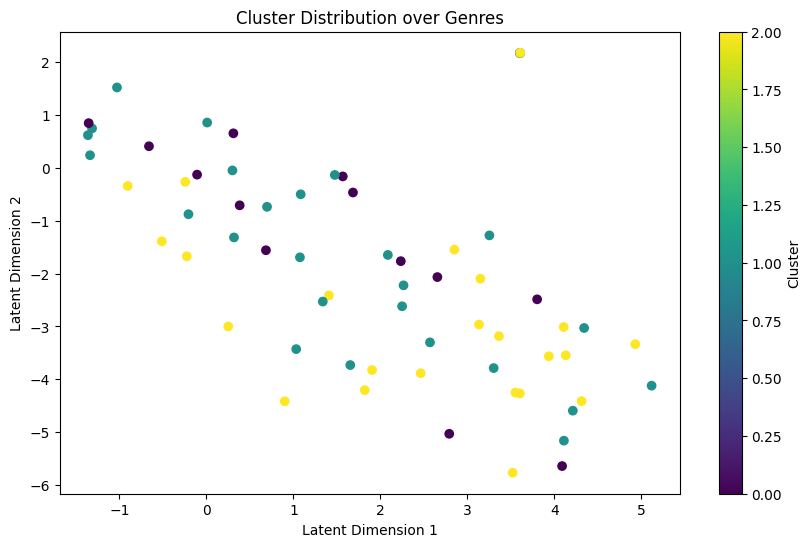

In [52]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    latent_features_df['latent_dim_1'],
    latent_features_df['latent_dim_2'],
    c=latent_features_df['cluster'],
    cmap='viridis',
    marker='o'
)
plt.title('Cluster Distribution over Genres')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

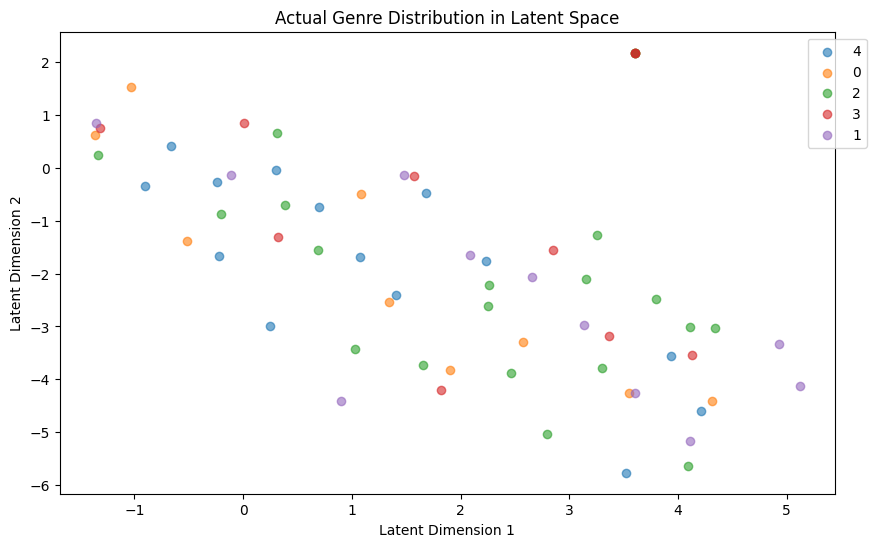

In [53]:
plt.figure(figsize=(10, 6))
for genre in latent_features_df['genre'].unique():
    subset = latent_features_df[latent_features_df['genre'] == genre]
    plt.scatter(subset['latent_dim_1'], subset['latent_dim_2'], label=genre, alpha=0.6)

plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1) # Moved legend outside for clarity
plt.title('Actual Genre Distribution in Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

In [39]:
# Save the data with the final clustering results (CVAE-based clustering)
data.to_csv("/content/drive/My Drive/Project 425/final_clustered_data_with_cvae_features.csv", index=False)
print("Final clustering results with CVAE features saved.")


Final clustering results with CVAE features saved.


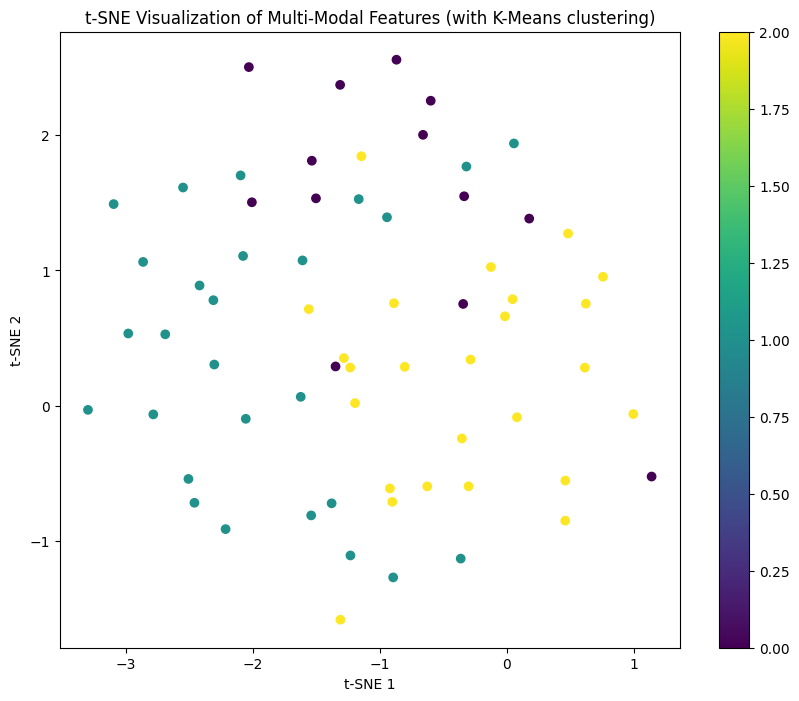

In [48]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce the multi-modal features to 2D
tsne = TSNE(n_components=2, random_state=42)
multi_modal_features_tsne = tsne.fit_transform(combined_features)

# Visualize the clusters in t-SNE space (using K-Means labels on multi-modal features)
plt.figure(figsize=(10, 8))
plt.scatter(multi_modal_features_tsne[:, 0], multi_modal_features_tsne[:, 1], c=labels_kmeans_multi, cmap='viridis')
plt.colorbar()
plt.title("t-SNE Visualization of Multi-Modal Features (with K-Means clustering)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()